In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
pd.set_option('display.float_format', '{:.6f}'.format)

# Import Model

In [4]:
jupyter_dir = os.path.abspath(str(Path()))
jupyter_dir

'E:\\git\\machine-learning-option-pricing'

In [5]:
models_path = os.path.join(jupyter_dir,'trained_models','trained_models')
models = os.listdir(models_path)
for i, path in enumerate(models):
    print(f"{i}   {path}")

0   2024_10_24 17-21-39 Deep Neural Network 7RMSE
1   2024_10_24 17-31-33 Deep Neural Network 50RMSE


In [6]:
model = models[1]
model

'2024_10_24 17-31-33 Deep Neural Network 50RMSE'

In [7]:
model_path = os.path.join(models_path,model)

In [8]:
model_files = os.listdir(model_path)
model_files

['.ipynb_checkpoints',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE insample.csv',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE outsample.csv',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE.pkl',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE.txt']

In [9]:
spec_path = os.path.join(model_path,[file for file in model_files if file.endswith('.txt')][0])

In [10]:
import joblib

In [11]:
model_fit = joblib.load(os.path.join(model_path,[file for file in model_files if file.endswith('.pkl')][0]))

In [12]:
with open(spec_path, "r") as specs:
    for line in specs:
        print(line.strip())

Thu Oct 24 17:26:41 2024
spot(s):
[1374.2  1377.99 1386.77 1386.98 1387.16 1391.82 1392.05 1395.15 1399.96
1401.5  1401.77 1402.74 1403.05 1406.48 1406.64 1409.82 1410.74 1412.12
1412.71 1414.71 1416.59 1416.97 1418.28 1420.46 1420.83 1422.42 1422.43
1423.07 1423.8  1424.27 1424.44 1426.09 1428.02 1428.7  1428.81 1430.36
1430.59 1430.69 1431.78 1433.55 1434.56 1434.69 1436.11 1437.38 1437.45
1438.07 1438.45 1438.91 1439.15 1439.97 1443.66 1444.24 1444.47 1445.71
1447.04 1447.77 1447.89 1448.38 1448.46 1449.6  1449.93 1451.23 1452.78
1455.05 1455.51 1456.3  1456.93 1457.51 1459.53 1468.23 1470.62 1471.33
1472.32 1480.49 1481.12 1482.47 1484.4  1486.09 1491.66 1494.22 1494.32
1495.27 1496.   1501.4  1502.3  1503.36 1505.49 1506.   1507.68 1507.84
1509.13 1512.52 1512.61 1513.95 1515.75 1522.16 1522.51 1523.96 1524.84]

strikes:
[1236.78    1240.191   1248.093   1248.282   1248.444   1252.638
1252.845   1255.635   1259.964   1261.35    1261.593   1262.466
1262.745   1265.832   1265.976   

In [13]:
model_files

['.ipynb_checkpoints',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE insample.csv',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE outsample.csv',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE.pkl',
 '2024_10_24 17-31-33 Deep Neural Network 50RMSE.txt']

In [14]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

outsample_path = os.path.join(model_path,[file for file in model_files if file.find('outsample') != -1][0])
outsample = pd.read_csv(outsample_path).iloc[:,1:]

insample_path = os.path.join(model_path,[file for file in model_files if file.find('insample') != -1][0])
insample = pd.read_csv(insample_path).iloc[:,1:]

# Test Model

In [15]:
maturities = outsample['days_to_maturity'].unique().tolist()
barrier_type_names = outsample['barrier_type_name'].unique().tolist()
ws = outsample['w'].unique().tolist()
print(f"\nmaturities:\n     maturities = {maturities}")
print(f"\ntypes:\n     barrier_type_names = {barrier_type_names}\n     ws = {ws}\n")


maturities:
     maturities = [60, 90, 180, 360, 540, 720]

types:
     barrier_type_names = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
     ws = ['call', 'put']



In [16]:
by_wbt = outsample.copy().set_index(['w','barrier_type_name','days_to_maturity']).sort_index()

In [17]:
RMSE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    columns = barrier_type_names,
    index = maturities
)

for t in maturities:
    for b in barrier_type_names:
        RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(slice(None), b, t),'outofsample_error'])**2))
print(f"\nRMSE:\n{RMSE}")


RMSE:
      DownOut    DownIn     UpOut      UpIn
60  46.449498 65.533974 72.458526 63.339406
90  41.780884 59.634436 66.566788 57.333274
180 30.809585 43.554319 49.879528 43.171495
360 33.236383 39.550818 47.128125 44.694930
540 36.889319 41.516010 49.971563 50.377792
720 39.222910 43.549105 51.281533 55.389337


In [18]:
MAE = pd.DataFrame(
    np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
    index = maturities,
    columns = barrier_type_names
)
for t in maturities:
    for b in barrier_type_names:
        MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(slice(None), b, t),'outofsample_error']))
print(f"\nMAE:\n{MAE}")


MAE:
      DownOut    DownIn     UpOut      UpIn
60  14.318900 15.079819 17.695323 14.118426
90  13.713987 14.211049 16.883650 13.057826
180 15.655750 14.262855 17.746454 14.811900
360 19.857831 18.182577 21.929279 24.340825
540 21.631697 23.098343 26.112764 31.759213
720 24.063239 27.536133 28.830288 38.061552


In [19]:
errors_bypayoff = {}
for w in ws:
    errors = {}
    print(
        f"\n         {'#'*(len(w)+5)}"
        f"\n         # {w}s #"
        f"\n         {'#'*(len(w)+5)}"
    )
    RMSE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
        )
    RMSE[w] = maturities
    RMSE = RMSE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            RMSE.loc[t,b] = np.sqrt(np.average((by_wbt.loc[(w, b, t),'outofsample_error'])**2))
    print(f"RMSE:\n{RMSE}")
    print()
    errors['RMSE'] = RMSE
    


    MAE = pd.DataFrame(
        np.zeros((len(maturities),len(barrier_type_names)),dtype=float),
        columns = barrier_type_names
    )
    MAE[w] = maturities
    MAE = MAE.set_index(w,drop=True)
    for t in maturities:
        for b in barrier_type_names:
            MAE.loc[t,b] = np.average(np.abs(by_wbt.loc[(w, b, t),'outofsample_error']))
    print(f"MAE:\n{MAE}")
    print()
    errors['MAE'] = MAE
    errors_bypayoff[w] = errors


         #########
         # calls #
         #########
RMSE:
       DownOut    DownIn     UpOut      UpIn
call                                        
60   52.516165 65.239641 75.046721 68.944305
90   47.292479 60.111110 70.133411 61.752649
180  34.136247 43.785546 54.805555 45.754568
360  34.007634 39.230916 52.492042 50.624920
540  36.804557 40.436932 54.787909 59.617616
720  38.076481 39.720853 56.307859 67.753345

MAE:
       DownOut    DownIn     UpOut      UpIn
call                                        
60   16.922033 11.645190 16.729518 15.330175
90   16.900652 11.184310 16.504693 14.128803
180  18.298243 10.007825 17.388811 18.432299
360  22.801115 11.474321 20.208186 34.727726
540  26.320499 14.684992 22.930392 46.587172
720  28.715147 17.008547 26.185262 56.294603


         ########
         # puts #
         ########
RMSE:
      DownOut    DownIn     UpOut      UpIn
put                                        
60  39.460919 65.826991 69.774391 57.187791
90  35.421829 59

In [20]:
max_MAE = max(errors['MAE'].values.flatten())
max_RMSE = max(errors['RMSE'].values.flatten())
plot_height = max(max_RMSE,max_MAE)*1.05
maturities = errors['MAE'].index.astype(str).tolist()

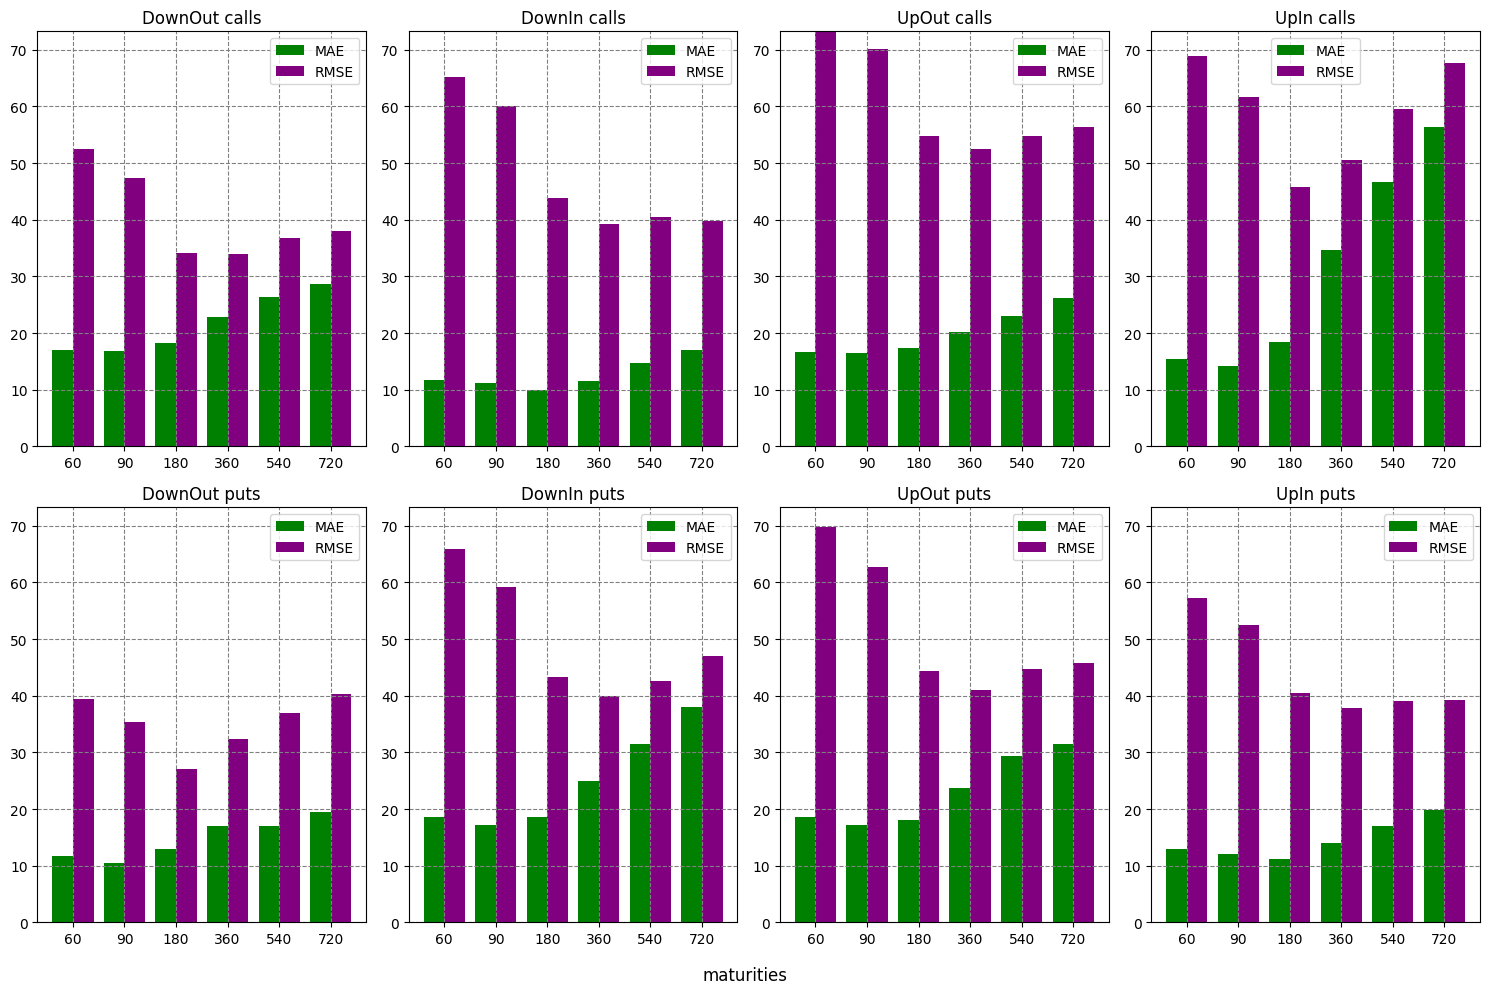

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(15,10))
bar_width = 0.4
i = 0
for w, errors in errors_bypayoff.items():
    for b in barrier_type_names:

        MAE = errors['MAE'][b]
        RMSE = errors['RMSE'][b]
        x_positions = range(len(maturities))
        axs[i // 4, i % 4].grid(True,which='both', linestyle='--', color='gray')
        axs[i // 4, i % 4].bar(
            [x - 0.5 * bar_width for x in x_positions], MAE, width=bar_width, color='green',label="MAE"
        )
        
        axs[i // 4, i % 4].bar(
            [x + 0.5 * bar_width for x in x_positions], RMSE, width=bar_width, color='purple', label="RMSE"
        )
        axs[i // 4, i % 4].set_title(f'{b} {w}s')
        axs[i // 4, i % 4].set_xticks(x_positions)
        axs[i // 4, i % 4].set_xticklabels(maturities)
        axs[i // 4, i % 4].set_ylim(0, plot_height)
        axs[i // 4, i % 4].legend()
        i += 1

fig.supxlabel('maturities')

plt.tight_layout()
plt.show()

In [22]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']

In [23]:
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('call',b,slice(None)),:].shape[0])


DownOut
376425

DownIn
376245

UpOut
376425

UpIn
376245


In [24]:
types  = ['DownOut', 'DownIn', 'UpOut', 'UpIn']
for b in types:
    print(f"\n{b}")
    print(by_wbt.loc[('put',b,slice(None)),:].shape[0])


DownOut
376425

DownIn
376245

UpOut
376425

UpIn
376245


In [25]:
outsample.loc[:,'security_type'] = outsample['w'] + outsample['barrier_type_name']

In [26]:
down_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_calls['barrier_price'])
outofsample_prediction = np.sum(down_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_calls['outofsample_prediction']-down_calls['barrier_price']))))
MAE


41026614.88816159
39974818.68925922

45.3947889289395


17.14074000152663

In [27]:
down_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Down')
    )
]
observed_price = np.sum(down_puts['barrier_price'])
outofsample_prediction = np.sum(down_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(down_puts['outofsample_prediction']-down_puts['barrier_price']))))
MAE


33837770.162849724
34057496.79112185

43.73611682430482


19.732669833831253

In [28]:
up_calls = outsample.copy()[
    (
        (outsample['w'] == 'call')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_calls['barrier_price'])
outofsample_prediction = np.sum(up_calls['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_calls['outofsample_prediction']-up_calls['barrier_price']))))
MAE


41015737.66707724
41421364.15697038

60.48721252897858


25.38234409906189

In [29]:
up_puts = outsample.copy()[
    (
        (outsample['w'] == 'put')
        &
        (outsample['updown'] =='Up')
    )
]
observed_price = np.sum(up_puts['barrier_price'])
outofsample_prediction = np.sum(up_puts['outofsample_prediction'])
print(f"\n{observed_price}\n{outofsample_prediction}\n")
RMSE = float(np.sqrt(np.mean(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price'])**2)))
print(RMSE)
MAE = float(np.average(np.abs(np.array(up_puts['outofsample_prediction']-up_puts['barrier_price']))))
MAE


33846120.79740113
35052748.703146026

48.988219350559795


18.74256372161419

In [30]:
outsample['calculation_date'] = pd.to_datetime(outsample['calculation_date'])
outsample = outsample[outsample['outofsample_error']<outsample.describe().loc['75%','outofsample_error']]
outsample_dates = np.sort(outsample['calculation_date'].unique())
outsample = outsample[outsample['calculation_date'].isin(outsample_dates)]
spots = outsample[['calculation_date','spot_price']].copy().drop_duplicates().set_index('calculation_date')
vols = outsample[['calculation_date','v0']].copy().drop_duplicates().set_index('calculation_date')**0.5*100

In [32]:
from tqdm import tqdm
MAES = []
RMSES = []
tot = len(outsample_dates)
bar = tqdm(total=tot,leave=False)
for i in range(len(outsample_dates)):
    test_dates = outsample_dates[(i):(i+1)]
    test_data = outsample[outsample['calculation_date'].isin(test_dates)]
    prediction = test_data['outofsample_prediction']
    target = test_data['observed_price']
    diff = prediction - target
    RMSES.append(np.sqrt(np.mean(diff**2)))
    MAES.append(np.mean(np.abs(diff)))
    bar.update(1)
bar.close()

In [33]:
MAE = pd.Series(MAES,index=outsample_dates)
RMSE = pd.Series(RMSES,index=outsample_dates)

In [34]:
MAE

2007-05-29    3.054989
2007-05-30    3.398684
2007-05-31    3.493386
2007-06-01    3.934123
2007-06-04    3.805177
                ...   
2012-12-24   11.993493
2012-12-26   12.162886
2012-12-27   12.248853
2012-12-28   12.497138
2012-12-31   11.812618
Length: 1384, dtype: float64

In [35]:
min_insample_spot = float(insample.describe().loc['min','spot_price'])
max_insample_spot = float(insample.describe().loc['max','spot_price'])

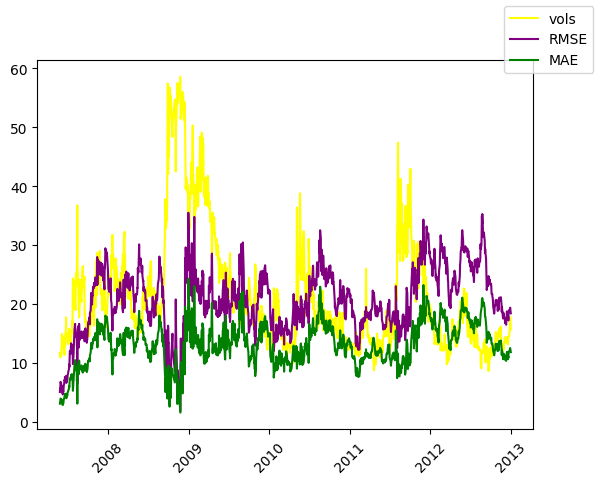

In [36]:
import matplotlib.pyplot as plt
import numpy as np

x = outsample_dates

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

ax1.plot(vols, color='yellow',label='vols')
ax1.plot(RMSE, color='purple', label='RMSE')
ax1.plot(MAE, color='green', label='MAE')

# ax2 = ax1.twinx()
# ax2.plot(spots[spots.index.isin(outsample_dates)], color='black', label='spot price')
# ax2.plot(x, np.tile(min_insample_spot,len(spots)),color='red')
# ax2.plot(x, np.tile(max_insample_spot,len(spots)),color='blue')



fig.legend()
plt.show()